In [57]:
import sys
sys.path.append('../../')

from amplify.client import FixstarsClient
import numpy as np
import os

from flow_solver.finite_element_model import FEM
from flow_solver.mesh_generator import MeshDoublePipe
from optimizer import Annealing, AnnealingSolver, PolyTop
from problems.topo_opt_level_set_fluid_flow import TopologyOptimizationProblem

# Topology Optimization for Double Pipe Problem

## Computational Mesh

In [58]:
# Create Meshes for double pipe problem.
n_elem_for_width = 48
n_elem_for_height = 32
mesh_v = MeshDoublePipe('Q2', n_elem_for_width, n_elem_for_height, width=1.5, height=1.0, inlet_height=1./6., outlet_height=1./6.)
mesh_p = MeshDoublePipe('Q1', n_elem_for_width, n_elem_for_height, width=1.5, height=1.0, inlet_height=1./6., outlet_height=1./6.)

## Finite Element Model

### Boundary Conditions

In [59]:
def upper_inlet_velocity(mesh, i_node):
    x = mesh.coords[i_node][0]; y = mesh.coords[i_node][1]
    v_x = 1-144*((y-3/4)**2); v_y = 0.0
    return np.array([v_x, v_y])

In [60]:
def lower_inlet_velocity(mesh, i_node):
    x = mesh.coords[i_node][0]; y = mesh.coords[i_node][1]
    v_x = 1-144*((y-1/4)**2); v_y = 0.0
    return np.array([v_x,v_y])

In [61]:
# Compute boundary velocities.
boundary_velocity = {key: [] for key in mesh_v.boundary_nodes.keys()}
for boundary in mesh_v.boundary_nodes.keys():
    for i_node in mesh_v.boundary_nodes[boundary]:
        if boundary == 'inlet_upper':
            boundary_velocity[boundary].append(upper_inlet_velocity(mesh_v, i_node))
        elif boundary == 'inlet_lower':
            boundary_velocity[boundary].append(lower_inlet_velocity(mesh_v, i_node))
        elif boundary == 'wall':
            boundary_velocity[boundary].append(np.zeros(2))
        if boundary == 'outlet_upper':
            boundary_velocity[boundary].append(upper_inlet_velocity(mesh_v, i_node))
        elif boundary == 'outlet_lower':
            boundary_velocity[boundary].append(lower_inlet_velocity(mesh_v, i_node))

# Set values for Dirichlet boundary conditions.
# Velocity.
BC = []
for boundary in mesh_v.boundary_nodes.keys():
    for i_node, node in enumerate(mesh_v.boundary_nodes[boundary]):
        if (boundary == 'inlet_upper' or 
            boundary == 'inlet_lower' or 
            boundary == 'wall' or 
            boundary == 'outlet_upper' or 
            boundary == 'outlet_lower'):
            BC.append([node, 0, boundary_velocity[boundary][i_node][0]])
            BC.append([node, 1, boundary_velocity[boundary][i_node][1]])
boundary_values_v = np.array(BC)

### Material Properties

In [62]:
viscosity = 1. 
density = 1.

# 
epsilon = 8.e-2

### Finite Element Model

In [63]:
fem = FEM(mesh_v, mesh_p, viscosity, density, epsilon)
fem.set_boudary_values_v(boundary_values_v)

Objective Function:0.001291177124467389


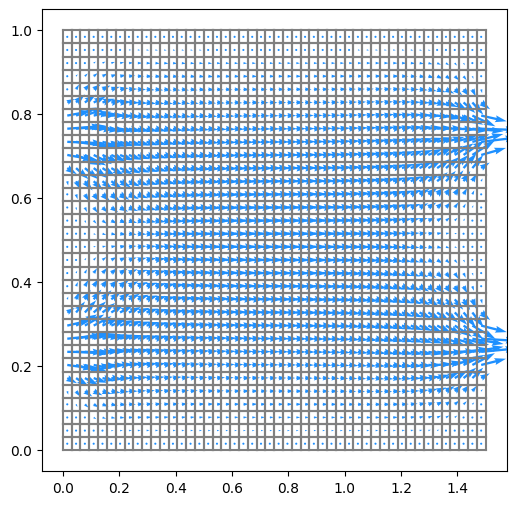

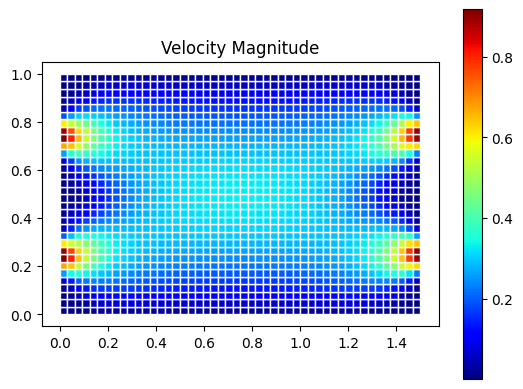

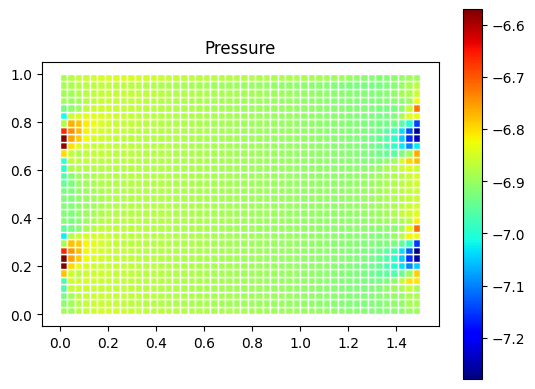

In [64]:
U, u_e, v_e, p_e, F, f=fem.solve()
print(f'Objective Function:{f}')
fem.plot_velocity_field([u_e, v_e])
fem.plot_velocity_magnitude([u_e, v_e])
fem.plot_pressure(p_e)

## Optimization

In [65]:
# Settings for Optimization.
volume_fraction_max = 1./3. # Volume fraction.
design_tolerance = 0.01 # Convergence tolerance on design variables.

active = {'classic': True,
          'annealing': True}

### Classical Optimization

In [66]:
density_initial = np.ones(mesh_v.n_elem) # Initial density, i.e., design variables, for each element.
density_min = 0.0; density_max = 1.0 # Lower and upper bound for design variables.

max_iterations = 150 # Max. number of optimization steps.

opt_OCMove = 0.2  # Allowable move step in OC update scheme
opt_OCEta = 0.5  # Exponent used in OC update scheme

q_values =  10. ** -np.arange(4, -1, -1)

############## q = 0.0001 ##############
Iteration: 1, Objective Function: 0.001291177124467389, Volume Fraction: 0.7999999999999999
Iteration: 2, Objective Function: 0.001308004134037117, Volume Fraction: 0.6
Iteration: 3, Objective Function: 0.0013359902370118693, Volume Fraction: 0.4000000000000001
Iteration: 4, Objective Function: 0.0013917538336917755, Volume Fraction: 0.3251666956973057
Iteration: 5, Objective Function: 0.0013897537807040477, Volume Fraction: 0.33927887999537126


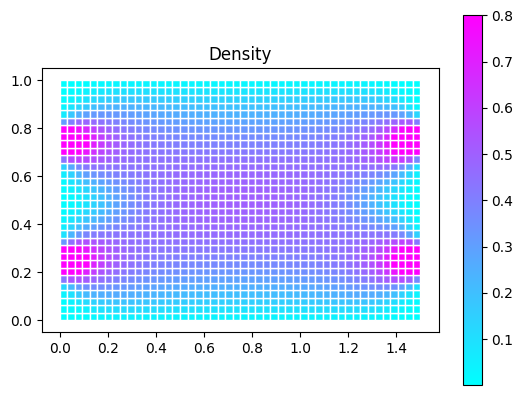

Iteration: 6, Objective Function: 0.001370112300683605, Volume Fraction: 0.3441791416810056
Iteration: 7, Objective Function: 0.0013669125545214455, Volume Fraction: 0.3441843846069312


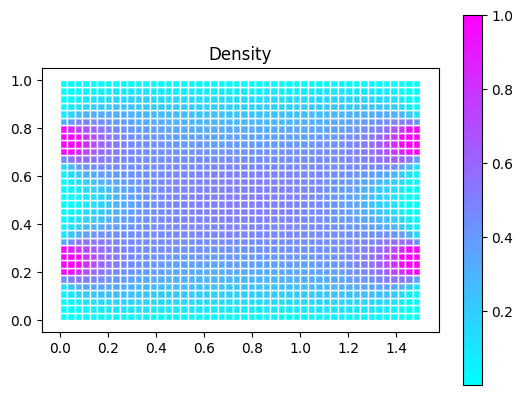

############## q = 0.001 ###############
Iteration: 1, Objective Function: 0.0020332769782265966, Volume Fraction: 0.3351600205645737
Iteration: 2, Objective Function: 0.0020636713387687734, Volume Fraction: 0.3350331395437327
Iteration: 3, Objective Function: 0.00206170630300819, Volume Fraction: 0.33510346151484116
Iteration: 4, Objective Function: 0.002060162935669914, Volume Fraction: 0.33520250832497794
Iteration: 5, Objective Function: 0.0020590316336788128, Volume Fraction: 0.33529909631943533


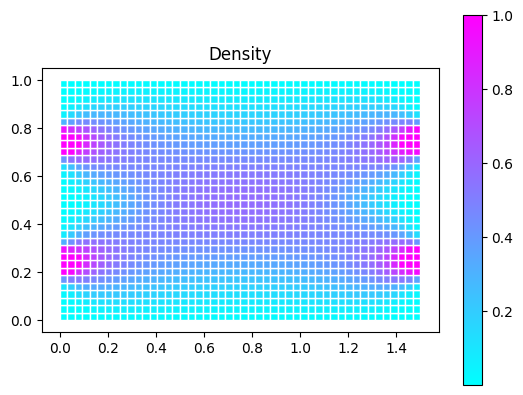

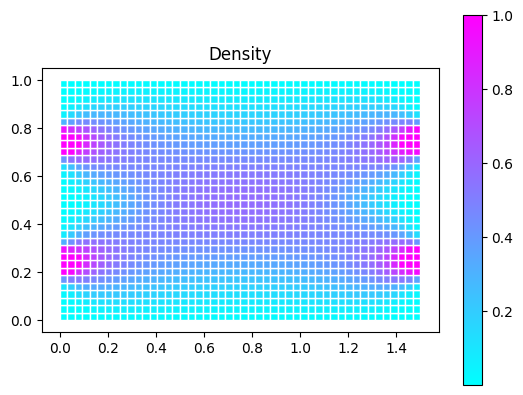

############### q = 0.01 ###############
Iteration: 1, Objective Function: 0.008121707173973274, Volume Fraction: 0.3332018947512448
Iteration: 2, Objective Function: 0.007774483024485323, Volume Fraction: 0.3332060571368915
Iteration: 3, Objective Function: 0.007369016487911067, Volume Fraction: 0.33325163536604346
Iteration: 4, Objective Function: 0.006945352016952709, Volume Fraction: 0.33318460109714204
Iteration: 5, Objective Function: 0.006495039763131496, Volume Fraction: 0.333447918859655


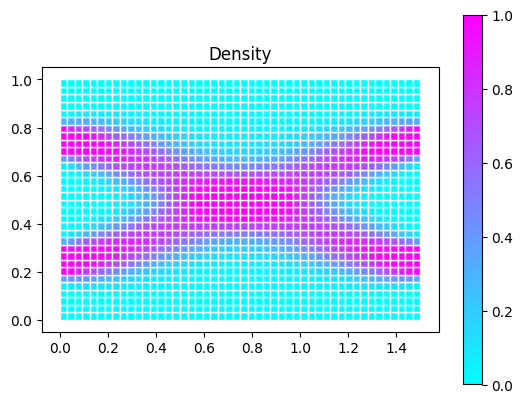

Iteration: 6, Objective Function: 0.006081902156914472, Volume Fraction: 0.3332059728884682
Iteration: 7, Objective Function: 0.005794575821443906, Volume Fraction: 0.33329370117164075
Iteration: 8, Objective Function: 0.0055942315607985516, Volume Fraction: 0.3332213362401843
Iteration: 9, Objective Function: 0.005469463031357702, Volume Fraction: 0.33345569111676804
Iteration: 10, Objective Function: 0.005376675632484732, Volume Fraction: 0.3333360161152799


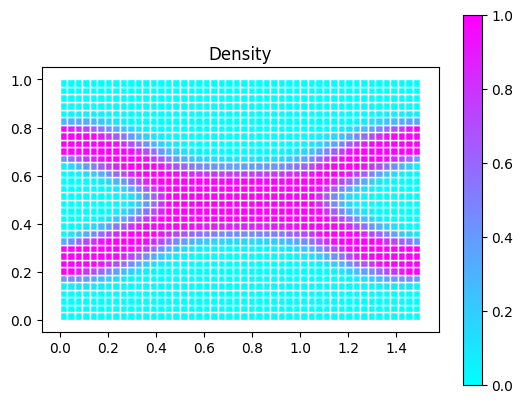

Iteration: 11, Objective Function: 0.005321621859039005, Volume Fraction: 0.33322698055919936
Iteration: 12, Objective Function: 0.005280100765280045, Volume Fraction: 0.33335685819203253
Iteration: 13, Objective Function: 0.005238285939042426, Volume Fraction: 0.33345975919284454
Iteration: 14, Objective Function: 0.005202600412998152, Volume Fraction: 0.3333647025350512
Iteration: 15, Objective Function: 0.0051775347882906326, Volume Fraction: 0.3333103969788899


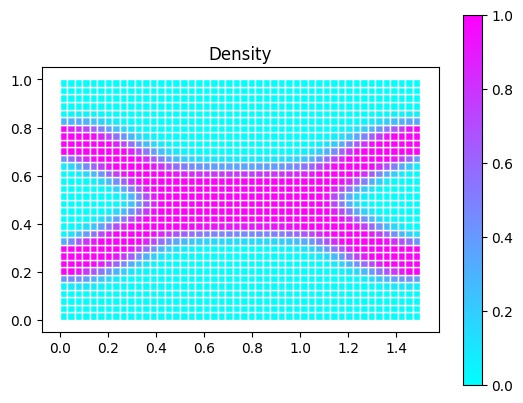

Iteration: 16, Objective Function: 0.005154027336586985, Volume Fraction: 0.3334162128154969
Iteration: 17, Objective Function: 0.005127330549080082, Volume Fraction: 0.33331028285751707
Iteration: 18, Objective Function: 0.005109895269459914, Volume Fraction: 0.3334105474295719
Iteration: 19, Objective Function: 0.0050874270148840006, Volume Fraction: 0.3333391614665544
Iteration: 20, Objective Function: 0.0050724827289538605, Volume Fraction: 0.33326959970876735


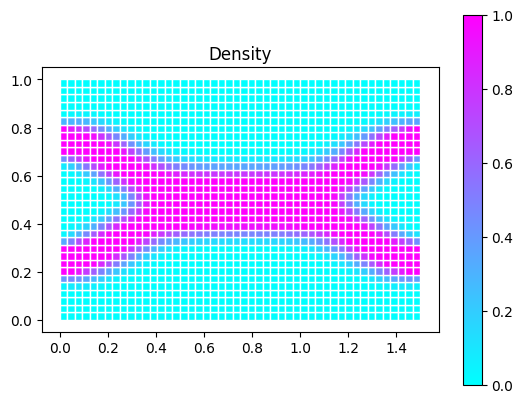

Iteration: 21, Objective Function: 0.005059042221228088, Volume Fraction: 0.3332630383963468
Iteration: 22, Objective Function: 0.005044866430012814, Volume Fraction: 0.3332582277373434
Iteration: 23, Objective Function: 0.005032058343238438, Volume Fraction: 0.333278759288507
Iteration: 24, Objective Function: 0.0050197660642327425, Volume Fraction: 0.3333156904055603
Iteration: 25, Objective Function: 0.005008210505197812, Volume Fraction: 0.3333541190182459


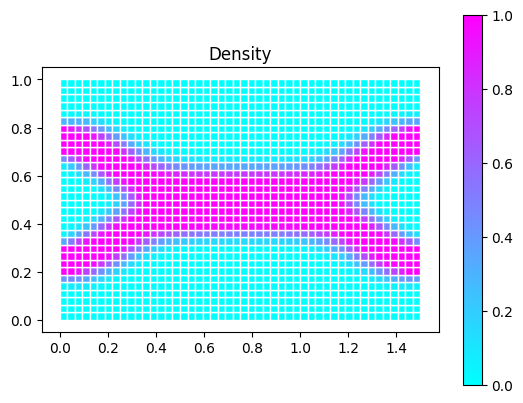

Iteration: 26, Objective Function: 0.004997714612641397, Volume Fraction: 0.3334344262639571
Iteration: 27, Objective Function: 0.004986778459939098, Volume Fraction: 0.3333277733687981
Iteration: 28, Objective Function: 0.004982758004864154, Volume Fraction: 0.333424815424556
Iteration: 29, Objective Function: 0.004972906865079831, Volume Fraction: 0.3333098328191662
Iteration: 30, Objective Function: 0.004970695885234428, Volume Fraction: 0.3333997230760366


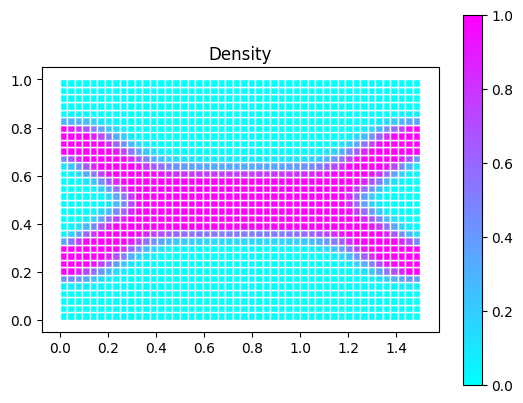

Iteration: 31, Objective Function: 0.004962405788592378, Volume Fraction: 0.33330571857390645
Iteration: 32, Objective Function: 0.004960728678657104, Volume Fraction: 0.3334120110255649
Iteration: 33, Objective Function: 0.0049532883505200775, Volume Fraction: 0.3333376925816391
Iteration: 34, Objective Function: 0.004952303038414414, Volume Fraction: 0.33322269545733274
Iteration: 35, Objective Function: 0.004953060819046092, Volume Fraction: 0.33333083226580756


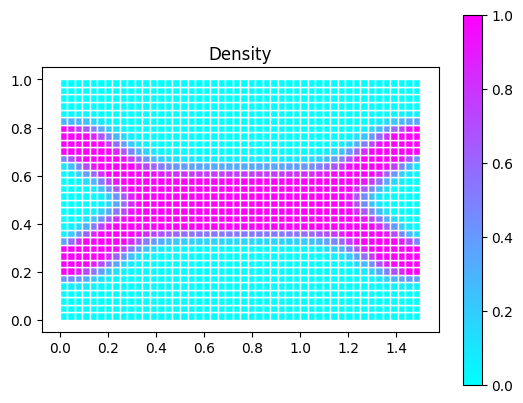

Iteration: 36, Objective Function: 0.004946975097338854, Volume Fraction: 0.33327013328161276
Iteration: 37, Objective Function: 0.004946662068260444, Volume Fraction: 0.3334057768610377
Iteration: 38, Objective Function: 0.004940305145387449, Volume Fraction: 0.3333744134092094
Iteration: 39, Objective Function: 0.004939480577933243, Volume Fraction: 0.3333148599985092
Iteration: 40, Objective Function: 0.004939668932365178, Volume Fraction: 0.3332530279435873


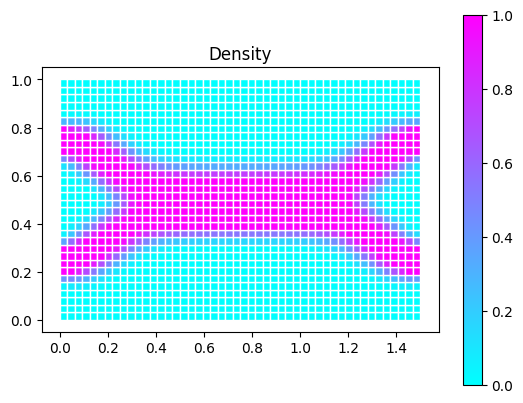

Iteration: 41, Objective Function: 0.00494001416183339, Volume Fraction: 0.3334230171706782
Iteration: 42, Objective Function: 0.004933015831350303, Volume Fraction: 0.3334357313169402
Iteration: 43, Objective Function: 0.004931141295130524, Volume Fraction: 0.33341546397685207
Iteration: 44, Objective Function: 0.004930446462214422, Volume Fraction: 0.33337989223350534
Iteration: 45, Objective Function: 0.004930355765929982, Volume Fraction: 0.33333800891132054


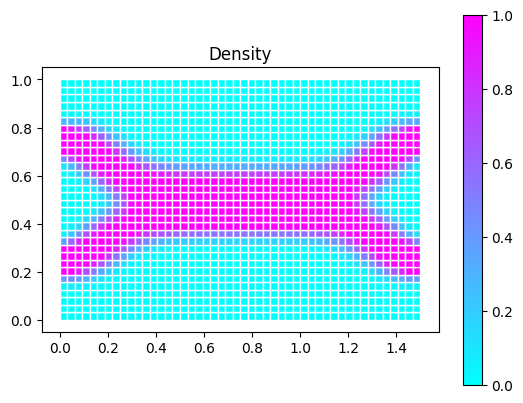

Iteration: 46, Objective Function: 0.004930579486814189, Volume Fraction: 0.3332979152437552


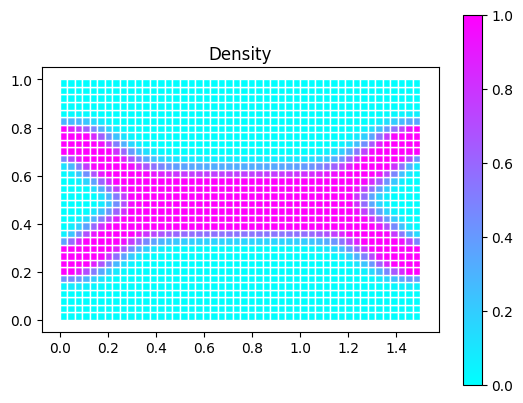

############### q = 0.1 ################
Iteration: 1, Objective Function: 0.01002174469995956, Volume Fraction: 0.3333289903370275
Iteration: 2, Objective Function: 0.008178329500719745, Volume Fraction: 0.3333477022461288
Iteration: 3, Objective Function: 0.007790173999525699, Volume Fraction: 0.33334490103393616
Iteration: 4, Objective Function: 0.007697614442650133, Volume Fraction: 0.3333354015164618
Iteration: 5, Objective Function: 0.007655551562632386, Volume Fraction: 0.3333404175858902


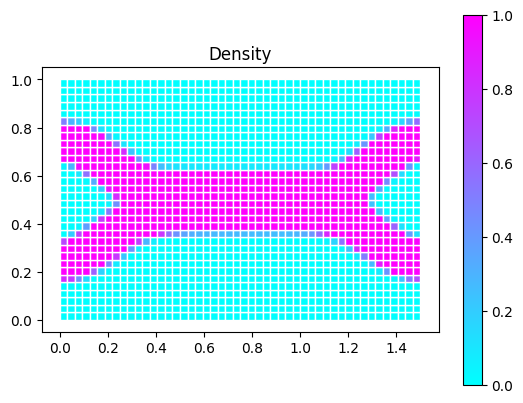

Iteration: 6, Objective Function: 0.007628966287842864, Volume Fraction: 0.33334065069565844
Iteration: 7, Objective Function: 0.007611507990725067, Volume Fraction: 0.3333257886376796
Iteration: 8, Objective Function: 0.007599792230130811, Volume Fraction: 0.33332054515425
Iteration: 9, Objective Function: 0.0075906802804109755, Volume Fraction: 0.3333256612038615
Iteration: 10, Objective Function: 0.00758298484508154, Volume Fraction: 0.33334417741291117


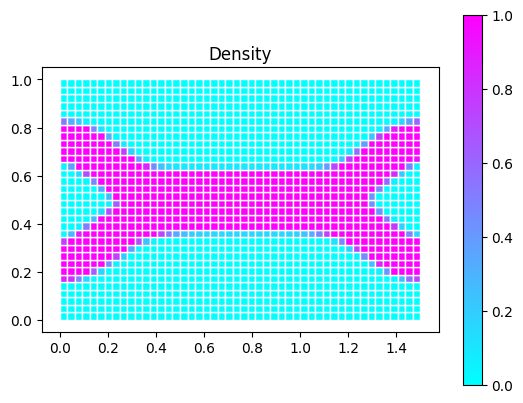

Iteration: 11, Objective Function: 0.007575744394160434, Volume Fraction: 0.3333199060676437
Iteration: 12, Objective Function: 0.007572206578480331, Volume Fraction: 0.333340846121136
Iteration: 13, Objective Function: 0.007566503408867123, Volume Fraction: 0.33332667069539257
Iteration: 14, Objective Function: 0.007563552951617395, Volume Fraction: 0.333341985515655
Iteration: 15, Objective Function: 0.0075590772466748645, Volume Fraction: 0.3333215905654157


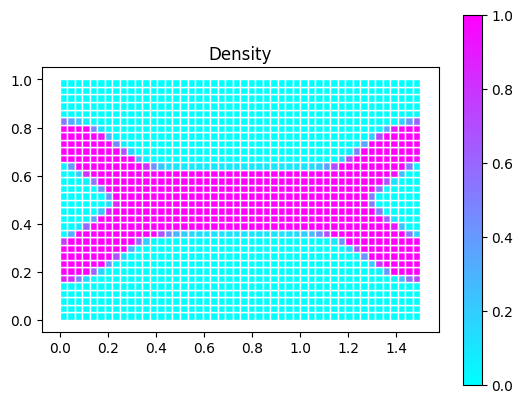

Iteration: 16, Objective Function: 0.007557071193232247, Volume Fraction: 0.33334594553198604
Iteration: 17, Objective Function: 0.007552353962098672, Volume Fraction: 0.3333186910389208
Iteration: 18, Objective Function: 0.007550973767359827, Volume Fraction: 0.3333436974800617
Iteration: 19, Objective Function: 0.007546342121274516, Volume Fraction: 0.3333244601168632
Iteration: 20, Objective Function: 0.007544665913708196, Volume Fraction: 0.3333324295194356


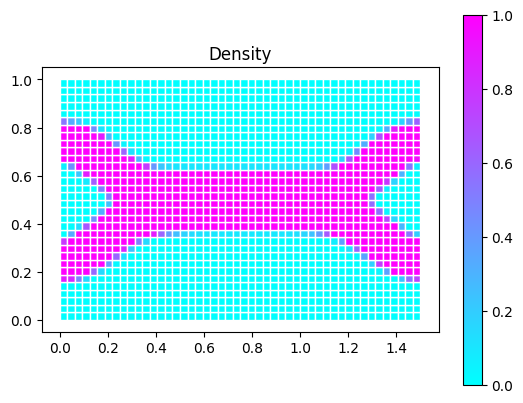

Iteration: 21, Objective Function: 0.007541682990192234, Volume Fraction: 0.33333138592863
Iteration: 22, Objective Function: 0.007539518352812478, Volume Fraction: 0.33333552604079547
Iteration: 23, Objective Function: 0.007537190545562585, Volume Fraction: 0.33334752192488065
Iteration: 24, Objective Function: 0.0075344634841704615, Volume Fraction: 0.3333429835555748
Iteration: 25, Objective Function: 0.00753279613273095, Volume Fraction: 0.3333349102015833


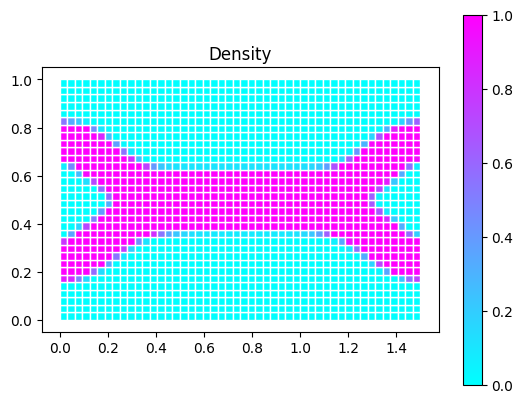

Iteration: 26, Objective Function: 0.007531322781977299, Volume Fraction: 0.3333309681869456
Iteration: 27, Objective Function: 0.00752951998576836, Volume Fraction: 0.3333327668326825
Iteration: 28, Objective Function: 0.007527256114016991, Volume Fraction: 0.3333339169019706
Iteration: 29, Objective Function: 0.007524907538458782, Volume Fraction: 0.33334391727503254
Iteration: 30, Objective Function: 0.007521837035678214, Volume Fraction: 0.33333779956332443


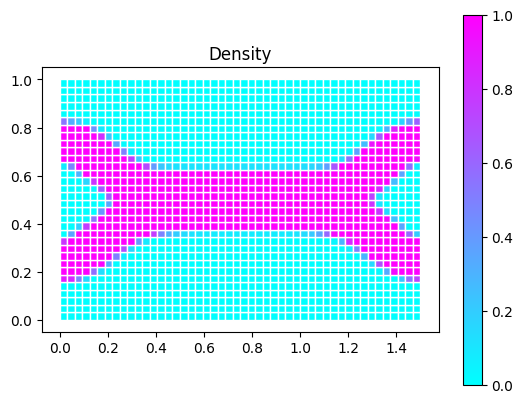

Iteration: 31, Objective Function: 0.007519570349882953, Volume Fraction: 0.3333356628393458
Iteration: 32, Objective Function: 0.007516865720994605, Volume Fraction: 0.33333809080248683
Iteration: 33, Objective Function: 0.0075136755447327164, Volume Fraction: 0.3333442903869018
Iteration: 34, Objective Function: 0.007510065966808582, Volume Fraction: 0.3333295368371222
Iteration: 35, Objective Function: 0.007507546648794458, Volume Fraction: 0.33332820845307426


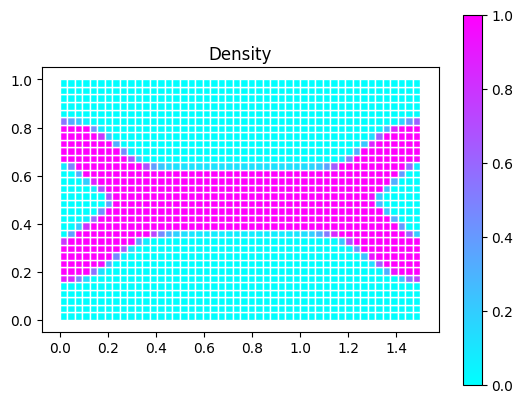

Iteration: 36, Objective Function: 0.0075045920662201275, Volume Fraction: 0.33333967440944173
Iteration: 37, Objective Function: 0.0075013906505824735, Volume Fraction: 0.33332523684092186
Iteration: 38, Objective Function: 0.007500382300304856, Volume Fraction: 0.33333968139394693
Iteration: 39, Objective Function: 0.0074979847722121155, Volume Fraction: 0.3333220368728997
Iteration: 40, Objective Function: 0.007497813559200709, Volume Fraction: 0.33334305536399267


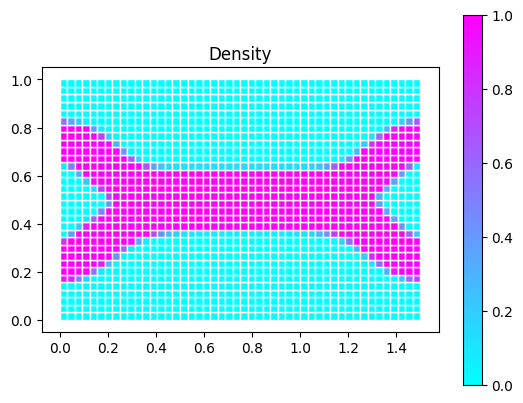

Iteration: 41, Objective Function: 0.0074953904787182545, Volume Fraction: 0.33333899220528257
Iteration: 42, Objective Function: 0.007494564163707079, Volume Fraction: 0.33332562040930497
Iteration: 43, Objective Function: 0.0074943005666517305, Volume Fraction: 0.3333343234711368
Iteration: 44, Objective Function: 0.007492651094512887, Volume Fraction: 0.3333307598250389
Iteration: 45, Objective Function: 0.007491747936685415, Volume Fraction: 0.3333275946696946


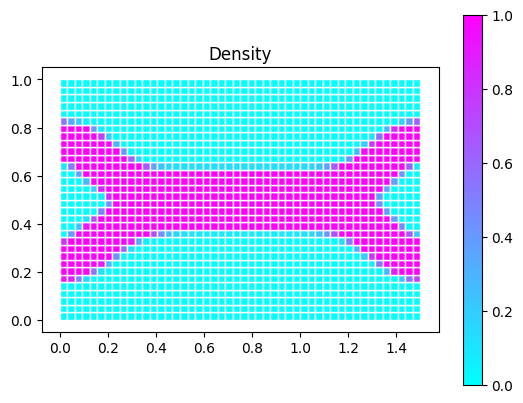

Iteration: 46, Objective Function: 0.007490829874191463, Volume Fraction: 0.33332830970686134
Iteration: 47, Objective Function: 0.007489706528378502, Volume Fraction: 0.33333180832551806
Iteration: 48, Objective Function: 0.007488455334228353, Volume Fraction: 0.33333456240274195
Iteration: 49, Objective Function: 0.007487283777686853, Volume Fraction: 0.3333344926942488
Iteration: 50, Objective Function: 0.007486324581998131, Volume Fraction: 0.33334460784420794


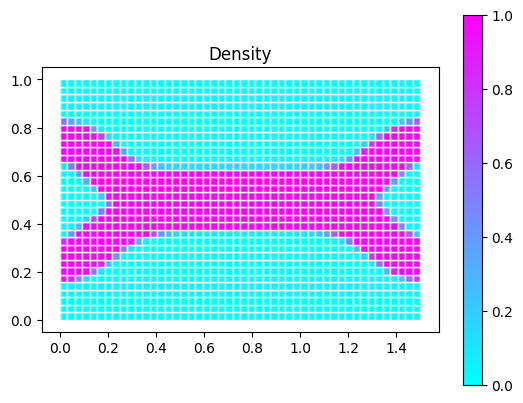

Iteration: 51, Objective Function: 0.0074848873781344335, Volume Fraction: 0.33332042398572265
Iteration: 52, Objective Function: 0.007485773930058086, Volume Fraction: 0.3333449335236514
Iteration: 53, Objective Function: 0.007483810027535053, Volume Fraction: 0.3333464564565858
Iteration: 54, Objective Function: 0.007483328550925181, Volume Fraction: 0.3333364441850121
Iteration: 55, Objective Function: 0.007483585552386004, Volume Fraction: 0.33332092189162416


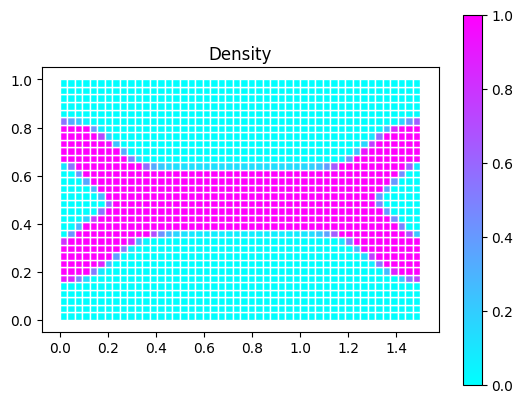

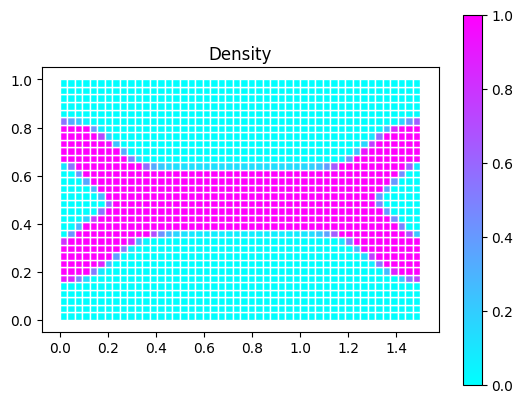

############### q = 1.0 ################
Iteration: 1, Objective Function: 0.008868463840978233, Volume Fraction: 0.3333268960370546
Iteration: 2, Objective Function: 0.008514528079088144, Volume Fraction: 0.3333376489325681
Iteration: 3, Objective Function: 0.008345567766436685, Volume Fraction: 0.3333298641586905
Iteration: 4, Objective Function: 0.008258269814145375, Volume Fraction: 0.33333465504361603
Iteration: 5, Objective Function: 0.008217521371912647, Volume Fraction: 0.3333339524071132


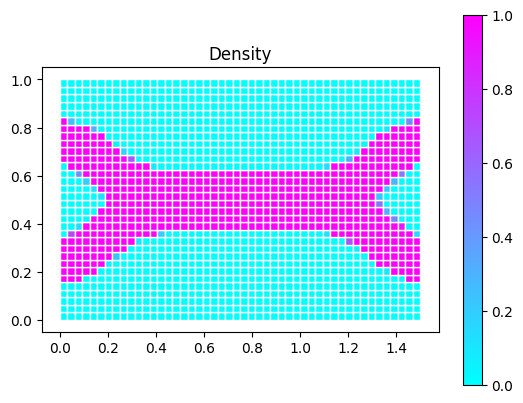

Iteration: 6, Objective Function: 0.008183023309072772, Volume Fraction: 0.3333314098144166
Iteration: 7, Objective Function: 0.008164448190416802, Volume Fraction: 0.3333354084887116
Iteration: 8, Objective Function: 0.008146370000612385, Volume Fraction: 0.3333321641177113
Iteration: 9, Objective Function: 0.008134207637721986, Volume Fraction: 0.33333399301983196
Iteration: 10, Objective Function: 0.00812861723020038, Volume Fraction: 0.33333263752560294


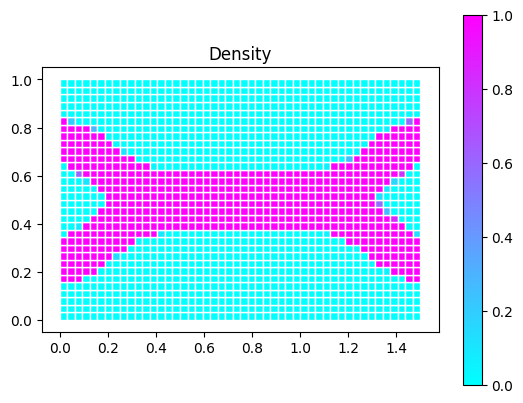

Iteration: 11, Objective Function: 0.008121555890623291, Volume Fraction: 0.3333325065399878
Iteration: 12, Objective Function: 0.008110674673702844, Volume Fraction: 0.3333334581189675
Iteration: 13, Objective Function: 0.008105101234490899, Volume Fraction: 0.3333327840016774
Iteration: 14, Objective Function: 0.008101738248160245, Volume Fraction: 0.33333240644452355
Iteration: 15, Objective Function: 0.008096613614364355, Volume Fraction: 0.3333336192146587


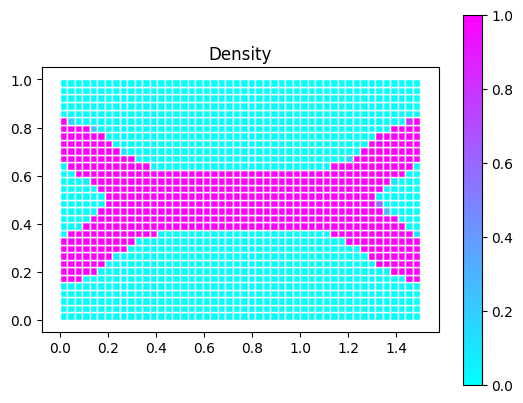

Iteration: 16, Objective Function: 0.008093479212846304, Volume Fraction: 0.33333382492600344
Iteration: 17, Objective Function: 0.008091052895374148, Volume Fraction: 0.3333333811152557
Iteration: 18, Objective Function: 0.008088617363845224, Volume Fraction: 0.3333333891833605
Iteration: 19, Objective Function: 0.008087955839746105, Volume Fraction: 0.33333363736515725
Iteration: 20, Objective Function: 0.008087178406897738, Volume Fraction: 0.33333312282944166


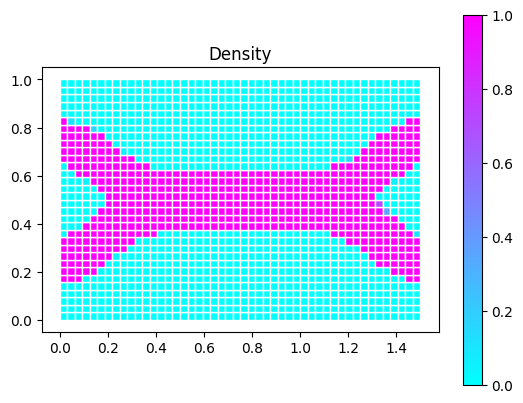

Iteration: 21, Objective Function: 0.008086281069189138, Volume Fraction: 0.3333330437239767
Iteration: 22, Objective Function: 0.008085076985139272, Volume Fraction: 0.33333281237654416
Iteration: 23, Objective Function: 0.00808337929400431, Volume Fraction: 0.3333329678265307
Iteration: 24, Objective Function: 0.008080651391055904, Volume Fraction: 0.3333335845582945
Iteration: 25, Objective Function: 0.008078173936705721, Volume Fraction: 0.33333350311806237


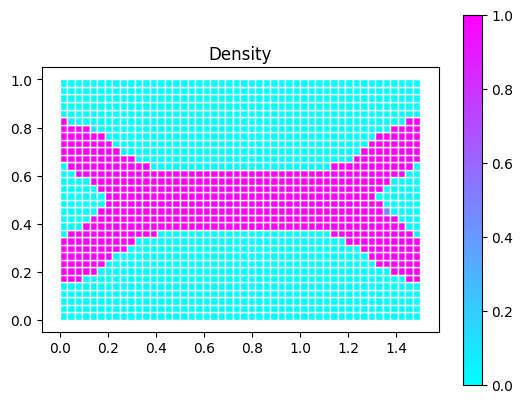

Iteration: 26, Objective Function: 0.008077248875803843, Volume Fraction: 0.3333331079947149
Iteration: 27, Objective Function: 0.008076207418149683, Volume Fraction: 0.3333332623836878
Iteration: 28, Objective Function: 0.008074954540297174, Volume Fraction: 0.3333332329404831
Iteration: 29, Objective Function: 0.008073504797483774, Volume Fraction: 0.3333335351717248
Iteration: 30, Objective Function: 0.008071789699537367, Volume Fraction: 0.33333319718271553


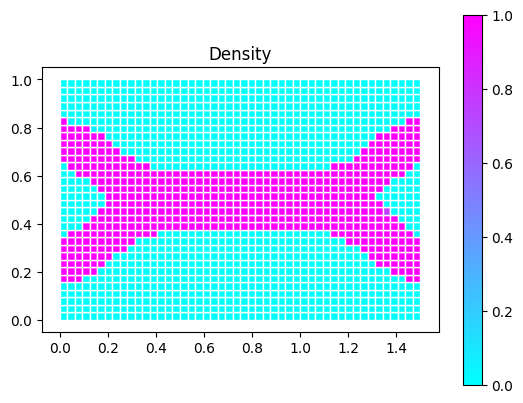

Iteration: 31, Objective Function: 0.008069893317776805, Volume Fraction: 0.3333332773455644
Iteration: 32, Objective Function: 0.008067778664760281, Volume Fraction: 0.33333307233540616
Iteration: 33, Objective Function: 0.008065207018342693, Volume Fraction: 0.33333340922992494
Iteration: 34, Objective Function: 0.00806046803328756, Volume Fraction: 0.3333335453003649
Iteration: 35, Objective Function: 0.008059452402822787, Volume Fraction: 0.33333326309053035


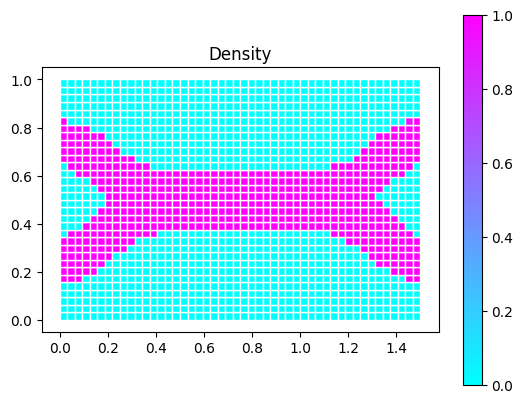

Iteration: 36, Objective Function: 0.008059186228574773, Volume Fraction: 0.33333319239021386
Iteration: 37, Objective Function: 0.008058936613640101, Volume Fraction: 0.33333324250219404
Iteration: 38, Objective Function: 0.008058710431559502, Volume Fraction: 0.3333332685769496


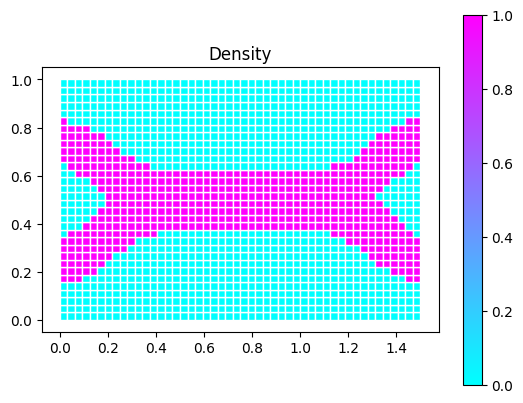

Final objective function (binary design): 0.008057653542262214, volume fraction 0.3333333333333333


In [67]:
poly_top = PolyTop(fem)
if active['classic']:
    density = poly_top.optimize(density_initial, density_min, density_max, volume_fraction_max,
                    design_tolerance, max_iterations, q_values,
                    opt_OCMove, opt_OCEta)
    
    binary_array = np.where(density >= 0.95, 1, 0)
    E = fem.viscosity/fem.epsilon*(1-binary_array)
    _, u, v, _, _, f = fem.solve(E)
    print(f'Final objective function (binary design): {f}, volume fraction {sum(binary_array)/mesh_p.area}')

### Optimization with Ising Machine Formulation

In [68]:
# Annealing Solver.
client = FixstarsClient()
client.parameters.timeout = 10000
client.parameters.outputs.duplicate = True
if os.path.exists('token_Fixstars.txt'):
    client.token = open('token_Fixstars.txt',"r").read().replace('\n', '')
if os.path.exists('proxy.txt'):
    client.proxy = open('proxy.txt',"r").read().replace('\n', '')

annealing_solver = AnnealingSolver(client)

In [73]:
# Topology Optimization Problem in Ising Machine Formulation.
n_qubits_per_variable = 9

hyperparameters = {
        'energy_dissipation': 3200.,
        'regularization': 2.,
        'volume_constraint': 160.,
        'char_func': 25.
}

topo_opt_problem = TopologyOptimizationProblem(fem.ne, n_qubits_per_variable, hyperparameters, volume_fraction_max)
topo_opt_problem.generate_discretizaton()

Iteration: 0, Objective Function: 0.020346737524760867, Volume Fraction: 0.33984375, Inconsistencies: 0


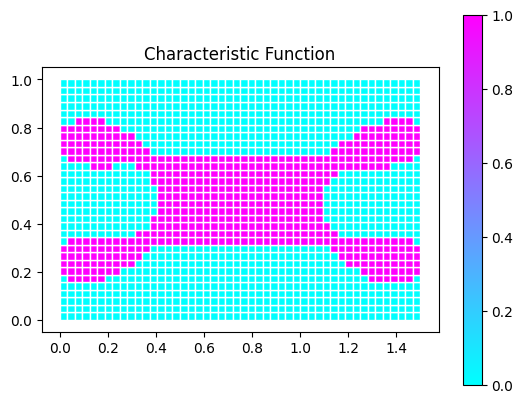

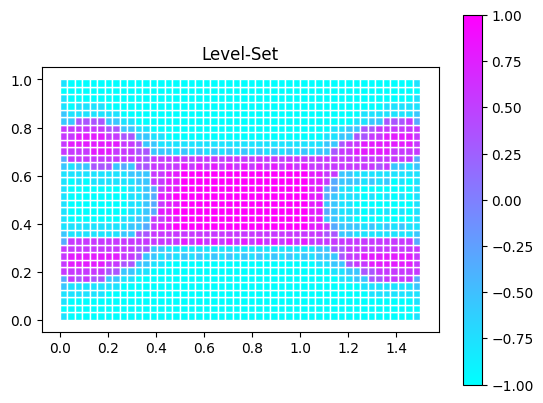

Max. change: 1.0
Iteration: 1, Objective Function: 0.014450268500805866, Volume Fraction: 0.3352864583333333, Inconsistencies: 0


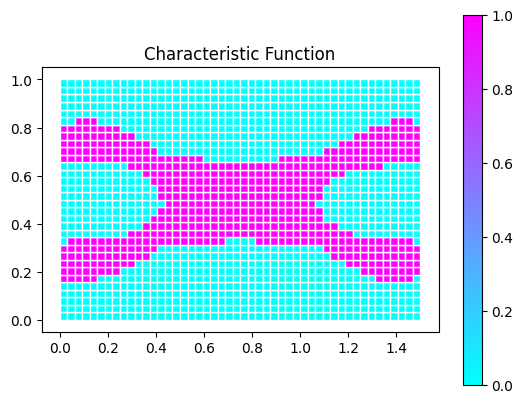

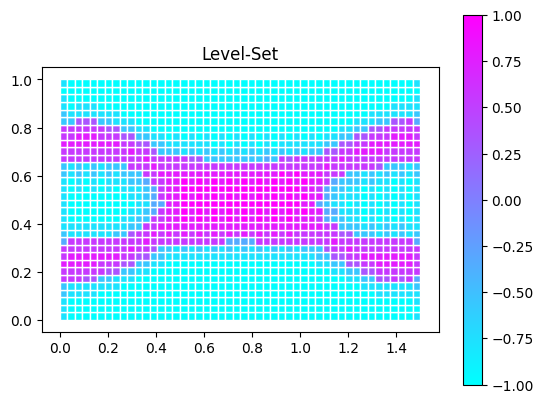

Max. change: 0.5555555555555556
Iteration: 2, Objective Function: 0.013153894221943567, Volume Fraction: 0.3346354166666667, Inconsistencies: 0


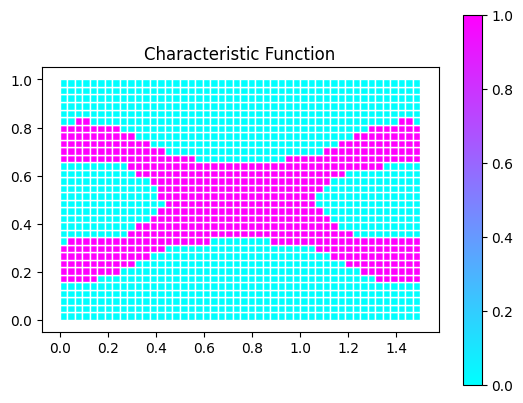

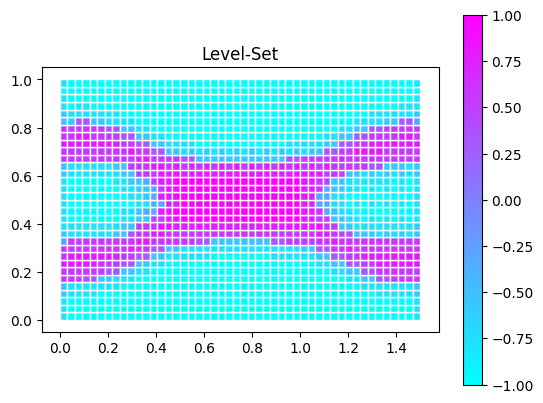

Max. change: 0.5555555555555556
Iteration: 3, Objective Function: 0.012494963080287703, Volume Fraction: 0.3346354166666667, Inconsistencies: 0


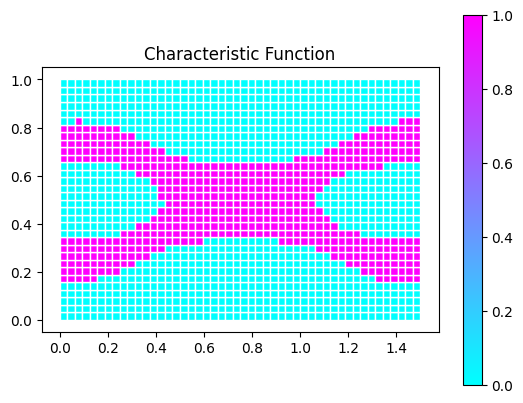

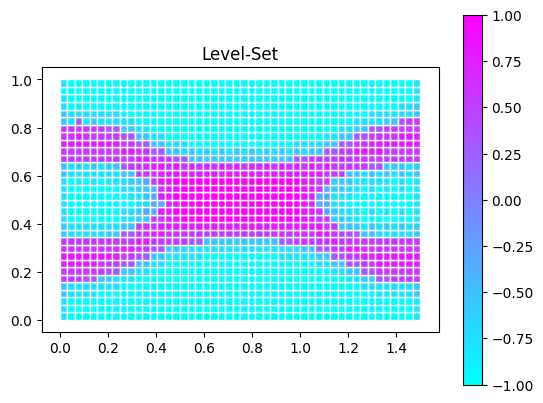

Max. change: 0.5555555555555556
Iteration: 4, Objective Function: 0.012078559780560725, Volume Fraction: 0.3346354166666667, Inconsistencies: 0


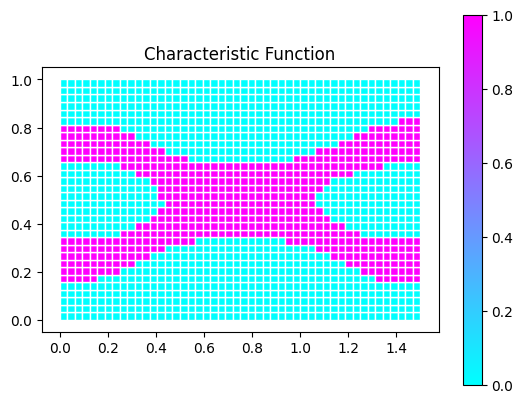

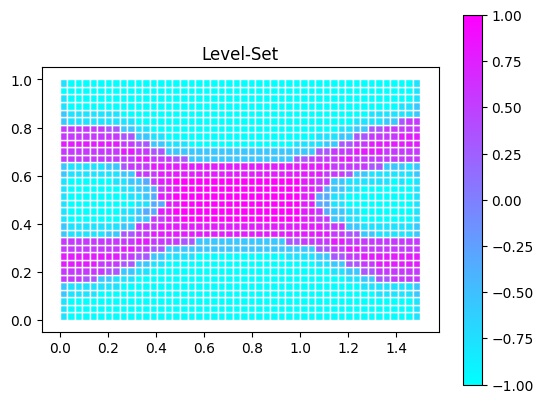

Max. change: 0.5555555555555556
Iteration: 5, Objective Function: 0.012078559780560725, Volume Fraction: 0.3346354166666667, Inconsistencies: 0


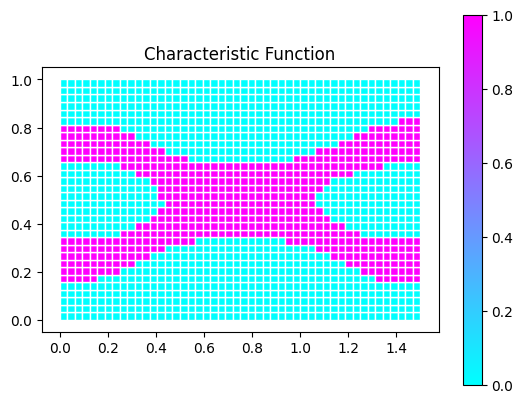

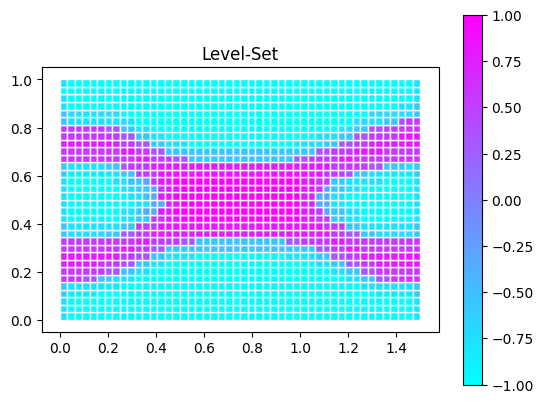

Max. change: 0.1111111111111111
Iteration: 6, Objective Function: 0.012078559780560725, Volume Fraction: 0.3346354166666667, Inconsistencies: 0


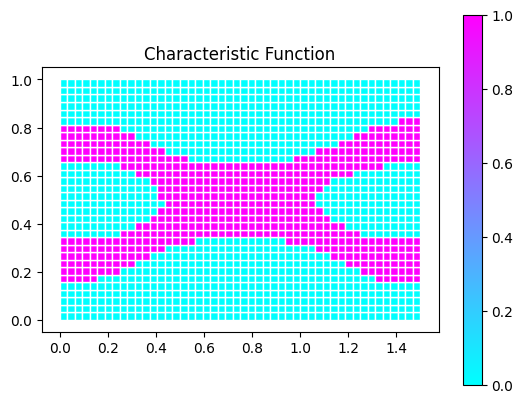

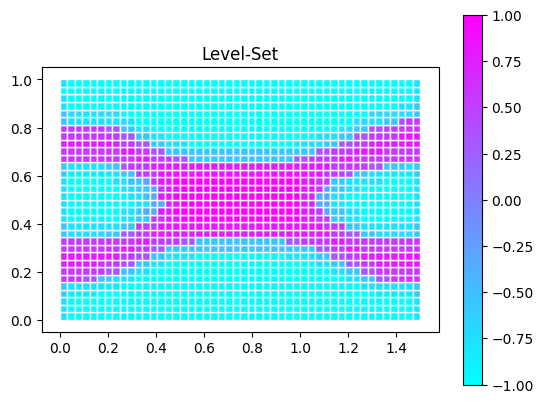

Max. change: 0.0


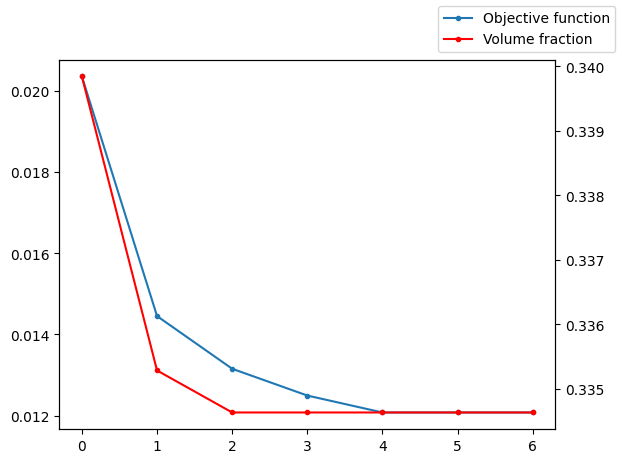

In [74]:
# Optimization
max_opt_steps = 15
# Initial scaled level-set values, i.e., design variables, for each element.
level_set_scaled_initial = np.ones(mesh_v.n_elem) 
annealing_optimizer = Annealing(fem)
if active['annealing']:
    annealing_optimizer.optimize(annealing_solver,
                                topo_opt_problem, 
                                level_set_scaled_initial,
                                max_opt_steps,
                                design_tolerance,
                                plot_steps=True)
    annealing_optimizer.plot_history()